# LabelSampler

The way the batchiterator samples the enxt labels is done via the label sampler. With the example data in the user guides we have for example the labels 'stroma',  'lymhpocytes', and 'tumor'. There a different built-in label samplers that sample the next label is specific way. In this guide we go over these labelsamplers. All labelsamplers, first **sort** the labels and can be used to **infinite** sample next labels and a **seed** can be set for reproducibilty.

in the user_configfor the batchiterator this can be configured with the "label_sampler" key.


## OrderedLabelSampler
samples labels in an ordered fashion:

In [30]:
from wholeslidedata.samplers.labelsampler import OrderedLabelSampler
labels = sorted(["tumor", "stroma", "lymphcytes"])

label_sampler = OrderedLabelSampler(labels, seed=123)
print('Ordered labels', labels)
for i in range(2):
    print('Iteration', i)
    for _ in labels:
        print("\t", next(label_sampler))
    print()

Ordered labels ['lymphcytes', 'stroma', 'tumor']
Iteration 0
	 lymphcytes
	 stroma
	 tumor

Iteration 1
	 lymphcytes
	 stroma
	 tumor



## RandomLabelSampler
samples labels randomly (with replacement):

In [31]:
from wholeslidedata.samplers.labelsampler import RandomLabelSampler
labels = sorted(["tumor", "stroma", "lymphcytes"])

label_sampler = RandomLabelSampler(labels, seed=123)
print('Ordered labels', labels)
sampled_labels = [next(label_sampler) for _ in range(10000)]
for label in labels:
    print("Sample counts", label, ":", sampled_labels.count(label))

Ordered labels ['lymphcytes', 'stroma', 'tumor']
Counts lymphcytes : 3338
Counts stroma : 3274
Counts tumor : 3388


## BalancedLabelSampler

samples randomly (without replacement, i.e.,makes sure that all labels have been sampled before a label is sampled again)

In [10]:
from wholeslidedata.samplers.labelsampler import BalancedLabelSampler
labels = sorted(["tumor", "stroma", "lymphocytes"])

label_sampler = BalancedLabelSampler(labels, seed=123)
print('Ordered labels', labels)
for i in range(2):
    print('Iteration', i)
    for _ in labels:
        print("\t", next(label_sampler))
    print()

Ordered labels ['lymphocytes', 'stroma', 'tumor']
Iteration 0
	 lymphocytes
	 stroma
	 tumor

Iteration 1
	 stroma
	 lymphocytes
	 tumor



## WeightedLabelSampler

In [7]:
from wholeslidedata.samplers.labelsampler import WeightedLabelSampler
import random

labels = {'lymphocytes': 0.6, 'stroma':0.2, 'tumor':0.2} 
sample_counts = 1000
label_sampler = WeightedLabelSampler(labels=labels)
sampled_labels = [next(label_sampler) for _ in range(sample_counts)]
for label in labels:
    print("Sample counts percentage", label, ":", sampled_labels.count(label)/sample_counts)
    

Sample counts percentage lymphocytes : 0.611
Sample counts percentage stroma : 0.191
Sample counts percentage tumor : 0.198


## AnnotationCountedLabelSampler
Labels with more annotations are sampled more often  based on the number of avaialble annotations per label. The annotations_per_label is an available property in the wholeslidedataset. With the Shuffle (default=True) argument you can set if the labels should be shuffeled or retreived in an orderly fashion (first all labels for for one label, then the second label etc..)


In [46]:
from wholeslidedata.samplers.labelsampler import AnnotationCountedLabelSampler
import random


labels = sorted(["tumor", "stroma", "lymphcytes"])
print('Ordered labels', labels)
annotations_per_label = {label: random.randint(1, 10) for label in labels}
print('Annotations per label', annotations_per_label)
print("\nShuffle=True")
label_sampler = AnnotationCountedLabelSampler(labels=labels, annotations_per_label=annotations_per_label)
sampled_labels = [next(label_sampler) for _ in range(sum(annotations_per_label.values()))]
print(sampled_labels)
for label in labels:
    print("Sample counts", label, ":", sampled_labels.count(label))
    

print("\nShuffle=False")
label_sampler = AnnotationCountedLabelSampler(labels=labels, annotations_per_label=annotations_per_label, shuffle=False)
sampled_labels = [next(label_sampler) for _ in range(sum(annotations_per_label.values()))]
print(sampled_labels)
for label in labels:
    print("Sample counts", label, ":", sampled_labels.count(label))

Ordered labels ['lymphcytes', 'stroma', 'tumor']
Annotations per label {'lymphcytes': 2, 'stroma': 9, 'tumor': 3}

Shuffle=True
['stroma', 'stroma', 'stroma', 'lymphcytes', 'stroma', 'stroma', 'stroma', 'tumor', 'stroma', 'lymphcytes', 'stroma', 'tumor', 'stroma', 'tumor']
Sample counts lymphcytes : 2
Sample counts stroma : 9
Sample counts tumor : 3

Shuffle=False
['lymphcytes', 'lymphcytes', 'stroma', 'stroma', 'stroma', 'stroma', 'stroma', 'stroma', 'stroma', 'stroma', 'stroma', 'tumor', 'tumor', 'tumor']
Sample counts lymphcytes : 2
Sample counts stroma : 9
Sample counts tumor : 3


## PixelCountedLabelSampler

In [1]:
from wholeslidedata.samplers.utils import one_hot_encoding
from wholeslidedata.samplers.labelsampler import PixelCountedLabelSampler
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Here we define the label_map. The label map is a dictionary in which labels/classes are mapped to an integer. 
# The integer should represent the ground truth

label_map = {'lymphocytes': 1, 'stroma': 2, 'tumor': 3}


# below we make some example ground truth batches with a single label (one-hot-encoded) with (batchsize, width, height) dimensions

# an example batch with only lymphocytes
lymphocytes_ybatch = one_hot_encoding(np.ones((1, 128,128), dtype='uint8'), label_map)

# an example batch with only stroma
stroma_ybatch = one_hot_encoding(np.ones((1, 128,128),  dtype='uint8') * 2, label_map)

# an example batch with only tumor
tumor_ybatch = one_hot_encoding(np.ones((1, 128,128),  dtype='uint8') * 3, label_map)

# test if expected output
assert np.all(lymphocytes_ybatch[..., 0] == 1)
assert np.all(stroma_ybatch[..., 1] == 1)
assert np.all(tumor_ybatch[..., 2] == 1)

example_ground_truth = {'lymphocytes': lymphocytes_ybatch, 'stroma': stroma_ybatch, 'tumor': tumor_ybatch}

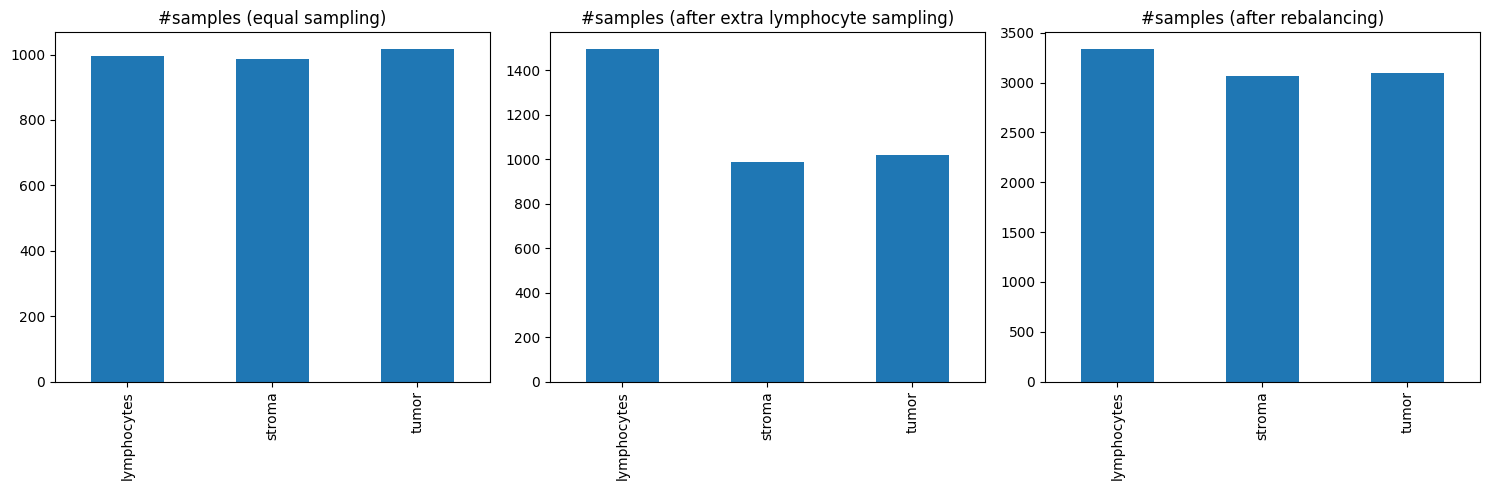

In [2]:
fig, axes = plt.subplots(1,3, figsize=(15,5))

# Lets create the pixel label controller!
pixel_label_sampler = PixelCountedLabelSampler(labels = list(label_map.keys()))

# list for keeping track of sampled labels
sampled_labels = []

# if no pixel were sampled each label should be sampled with the same probabilty

# sample new labels
for i in range(3000):
    #sample next label
    label = next(pixel_label_sampler)
    
    # keep track of sampled labels
    sampled_labels.append(label)
    
    # update the pixel label controller with ground truth values of the sampled label
    pixel_label_sampler.update((None, example_ground_truth[label]))
    

pd.Series(sampled_labels).value_counts().reindex(["lymphocytes", "stroma", "tumor"]).plot(kind='bar', ax=axes[0])
axes[0].set_title('#samples (equal sampling)')



# EXTRA Lymphocyte SAMPLING: sample a lot of lymphocytes samples and update pixel counter with lymphocyte ground truth
for i in range(500):
    sampled_labels.append('lymphocytes')
    pixel_label_sampler.update((None, lymphocytes_ybatch))

pd.Series(sampled_labels).value_counts().reindex(["lymphocytes", "stroma", "tumor"]).plot(kind='bar', ax=axes[1])
axes[1].set_title('#samples (after extra lymphocyte sampling)')



# REBALANCING: lymphocytes should be now be sampled less often. 
for i in range(6000):
    
    #sample next label
    label = next(pixel_label_sampler)
    
    # keep track of sampled labels
    sampled_labels.append(label)
    
    # update the pixel label controller with ground truth values of the sampled label
    pixel_label_sampler.update((None, example_ground_truth[label]))
    
pd.Series(sampled_labels).value_counts().reindex(["lymphocytes", "stroma", "tumor"]).plot(kind='bar',  ax=axes[2])
axes[2].set_title('#samples (after rebalancing)')
plt.tight_layout()
plt.show()